In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

In [3]:
from sklearn.preprocessing import label_binarize, StandardScaler
sc = StandardScaler() # Creating instance for standard scaler

In [4]:
from sklearn.model_selection import cross_val_score, StratifiedKFold

In [5]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_curve, auc, roc_auc_score, precision_score

In [6]:
data = pd.read_csv("upscaled_synthetic_data.csv")

In [7]:
data.head(5)
print(data.shape)

(21050, 8)


In [8]:
df = data.copy()

# Splitting the Data into Train and Test Set

In [9]:
train_set, test_set = train_test_split(df, test_size=0.1, random_state=2022, stratify = data["category"])

In [10]:
x_tr = train_set.drop(["category"], axis = 1).to_numpy()

y_tr = train_set["category"].to_numpy()

In [11]:
x_tr_scaled = sc.fit_transform(x_tr)

# Applying K-Fold Cross Validation on Random Forest

In [12]:
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=2022)

In [13]:
model = RandomForestClassifier()

In [14]:
scores = cross_val_score(model, x_tr_scaled, y_tr, scoring='accuracy', cv=kfold, n_jobs=-1)

# report performance
print('Accuracy: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))

Accuracy: 0.809 (0.011)


# Parameter Tunning for Random Forest

In [15]:
x_train, x_val, y_train, y_val = train_test_split(x_tr_scaled, y_tr,
                                                  test_size=0.1,
                                                  random_state = 2022,
                                                  stratify = pd.Series(y_tr))

fr = []
for i in range(0,121, 5):
    if i==0:
        i=1
    model = RandomForestClassifier(n_estimators = i, random_state = 2022)
    
    model.fit(x_train, y_train)
    predict = model.predict(x_val)
    
    actual = y_val
    
    score = accuracy_score(actual, predict)
    
    dict1 = {
        "No. of Trees": i,
        "Accuracy" : score
    }
    
    fr.append(dict1)

In [16]:
results = pd.DataFrame(fr)
results.to_csv("RF_results_vs_trees.csv", index = False)
results

,No. of Trees,Accuracy
0,1,0.684960
1,5,0.776253
2,10,0.797361
3,15,0.806332
4,20,0.809499
5,25,0.810026
6,30,0.814248
7,35,0.810026
8,40,0.814776
9,45,0.813720


In [26]:
results = pd.read_csv("RF_results_vs_trees.csv")

# Plotting No of Trees vs Accuracy

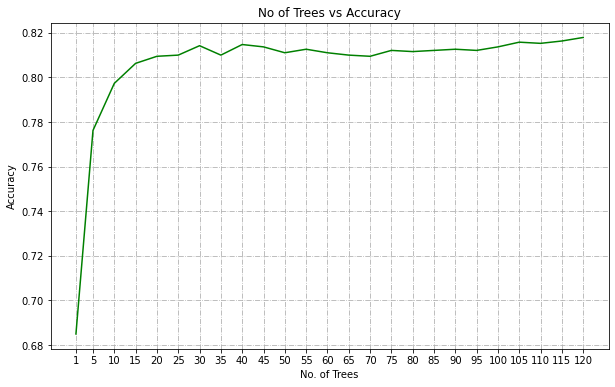

In [29]:
fig, ax1 = plt.subplots(figsize = (10,6))

ax1.plot(results["No. of Trees"], results["Accuracy"], 'g-')

ax1.set_xlabel('No. of Trees')
ax1.set_ylabel('Accuracy', color='black')

ax1.grid(True, linestyle='-.')

tickpos = results["No. of Trees"]

plt.xticks(tickpos,tickpos)
plt.title("No of Trees vs Accuracy")

plt.savefig("No of Trees vs Accuracy.jpeg", bbox_inches = "tight")
plt.show()

# We will select 115 number of trees for model selection

This will be our model which will be used or Testing



RandomForestClassifier(n_estimators = 115, random_state = 2022)

In [12]:
x_train, x_val, y_train, y_val = train_test_split(x_tr_scaled, y_tr,
                                                  test_size=0.1,
                                                  random_state = 2022,
                                                  stratify = pd.Series(y_tr))

model = RandomForestClassifier(n_estimators = 115, random_state = 2022)
  
model.fit(x_train, y_train)

predict = model.predict(x_val)
    
actual = y_val

score = accuracy_score(actual, predict)

class_report = classification_report(actual, predict)

conf_mat = confusion_matrix(actual, predict)

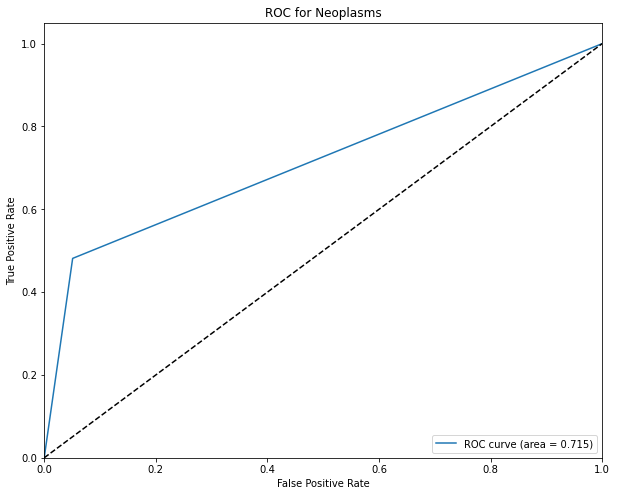

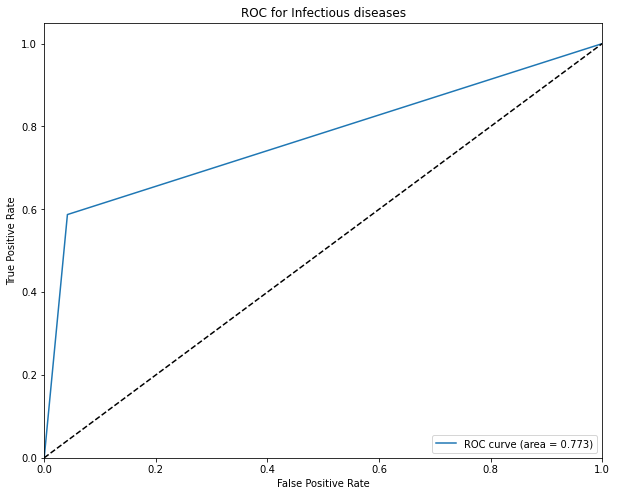

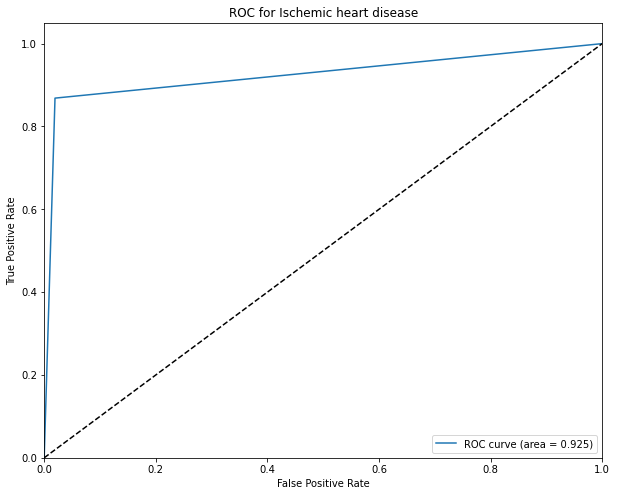

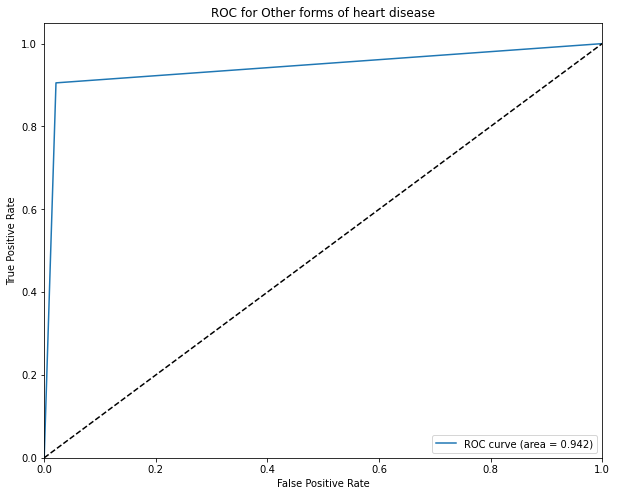

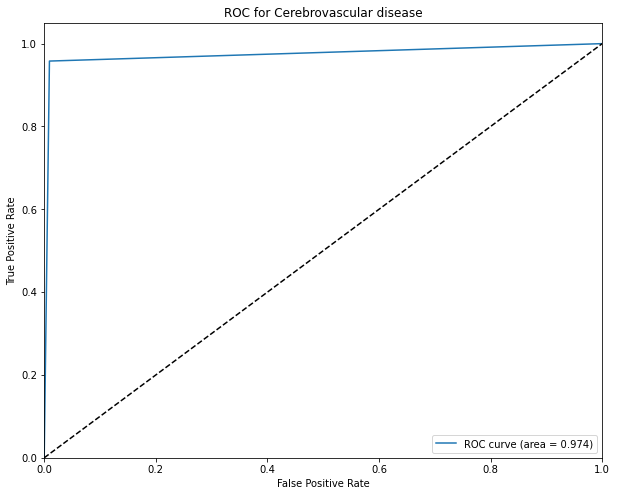

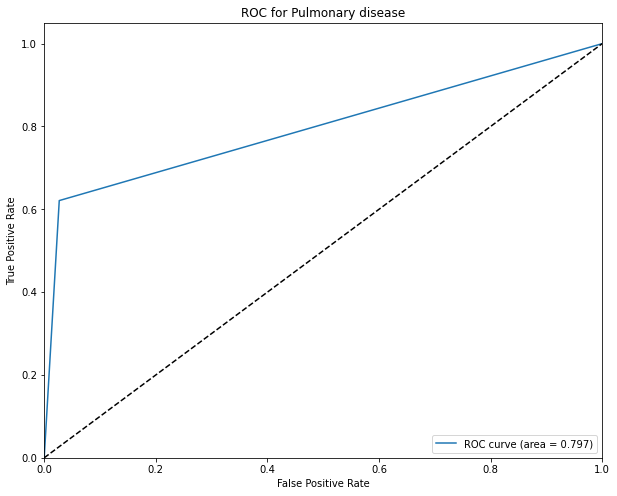

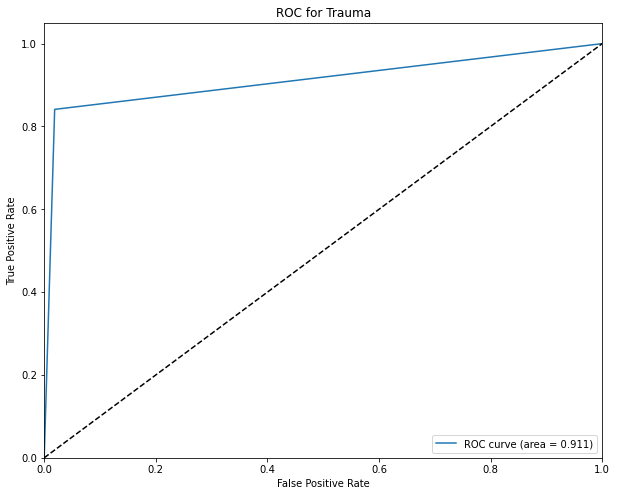

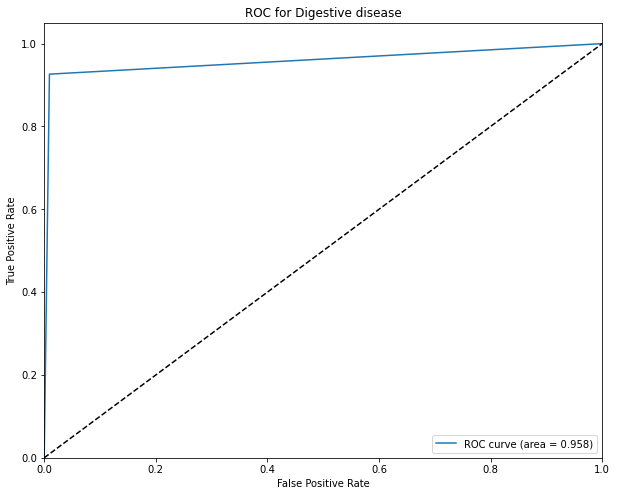

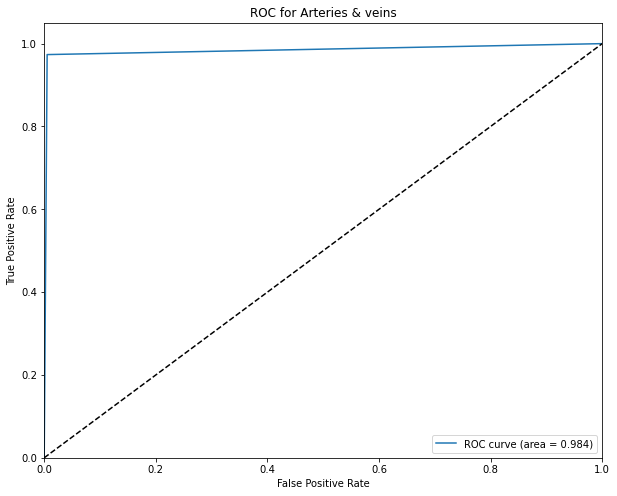

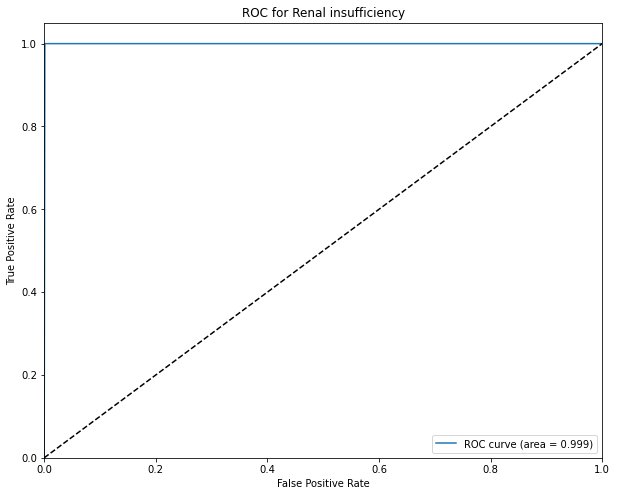

In [19]:
actual_bin = label_binarize(actual, classes = [0,1,2,3,4,5,6,7,8,9])
predict_bin = label_binarize(predict, classes = [0,1,2,3,4,5,6,7,8,9])

cat = ['Neoplasms',
     'Infectious diseases',
     'Ischemic heart disease',
     'Other forms of heart disease',
     'Cerebrovascular disease',
     'Pulmonary disease',
     'Trauma',
     'Digestive disease',
     'Arteries & veins',
     'Renal insufficiency']

n_classes = len(cat)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(actual_bin[:, i], predict_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot of a ROC curve for a specific class
for i in range(n_classes):
    cat_name = cat[i]
    plt.figure(figsize = (10,8))
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.3f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC for {cat_name}')
    plt.legend(loc="lower right")
    plt.savefig(f"ROC_for_{cat_name}.jpg", bbox_inches = "tight")
    plt.show()

In [13]:
def roc_auc_score_multiclass(actual_class, pred_class, average = "macro"):
    
    #creating a set of all the unique classes using the actual class list
    unique_class = set(actual_class)
    roc_auc_dict = {}
    for per_class in unique_class:
        
        #creating a list of all the classes except the current class 
        other_class = [x for x in unique_class if x != per_class]

        #marking the current class as 1 and all other classes as 0
        new_actual_class = [0 if x in other_class else 1 for x in actual_class]
        new_pred_class = [0 if x in other_class else 1 for x in pred_class]

        #using the sklearn metrics method to calculate the roc_auc_score
        roc_auc = roc_auc_score(new_actual_class, new_pred_class, average = average)
        roc_auc_dict[per_class] = roc_auc

    return roc_auc_dict

In [21]:
roc_auc_score_multiclass(actual, predict)

{0: 0.7152424992401546,
 1: 0.7728418839204303,
 2: 0.9245331069609508,
 3: 0.9420743941966353,
 4: 0.9742552863096156,
 5: 0.7970365797190925,
 6: 0.9112562570944752,
 7: 0.9584658126254052,
 8: 0.9841347376517365,
 9: 0.9994138335287222}

In [14]:
roc_auc_score_multiclass(actual, predict)

{0: 0.7152424992401546,
 1: 0.7728418839204303,
 2: 0.9245331069609508,
 3: 0.9420743941966353,
 4: 0.9742552863096156,
 5: 0.7970365797190925,
 6: 0.9112562570944752,
 7: 0.9584658126254052,
 8: 0.9841347376517365,
 9: 0.9994138335287222}

# Accuracy

In [15]:
score

0.816358839050132

# Classification Report

In [18]:
cat = ['Neoplasms',
     'Infectious diseases',
     'Ischemic heart disease',
     'Other forms of heart disease',
     'Cerebrovascular disease',
     'Pulmonary disease',
     'Trauma',
     'Digestive disease',
     'Arteries & veins',
     'Renal insufficiency']

In [51]:
class_report = pd.DataFrame(classification_report(actual, predict, target_names =cat, output_dict=True)).T
class_report.to_csv("Classification_report.csv")

In [19]:
pd.DataFrame(classification_report(actual, predict, target_names =cat, output_dict=True)).T

,precision,recall,f1-score,support
Neoplasms,0.511236,0.481481,0.495913,189.000000
Infectious diseases,0.609890,0.587302,0.598383,189.000000
Ischemic heart disease,0.833333,0.868421,0.850515,190.000000
Other forms of heart disease,0.826923,0.905263,0.864322,190.000000
Cerebrovascular disease,0.919192,0.957895,0.938144,190.000000
Pulmonary disease,0.719512,0.621053,0.666667,190.000000
Trauma,0.832461,0.841270,0.836842,189.000000
Digestive disease,0.916667,0.926316,0.921466,190.000000
Arteries & veins,0.953368,0.973545,0.963351,189.000000
Renal insufficiency,0.989529,1.000000,0.994737,189.000000


# Confusion Matrix

In [20]:
pd.DataFrame(conf_mat)

,0,1,2,3,4,5,6,7,8,9
0,91,45,10,7,3,18,11,2,1,1
1,49,111,2,8,1,10,5,1,2,0
2,7,4,165,4,1,3,2,4,0,0
3,3,1,2,172,4,3,1,3,1,0
4,1,0,0,4,182,2,0,1,0,0
5,22,15,10,5,6,118,9,3,1,1
6,2,5,7,4,1,9,159,2,0,0
7,3,0,2,1,0,1,3,176,4,0
8,0,1,0,3,0,0,1,0,184,0
9,0,0,0,0,0,0,0,0,0,189


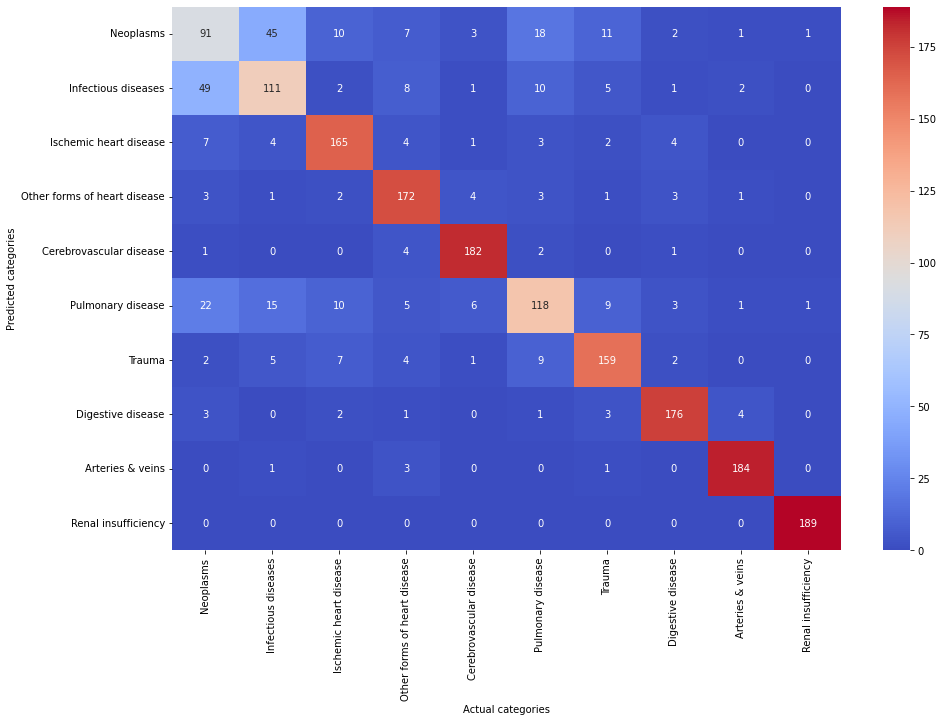

In [35]:
plt.figure(figsize = (15,10))
sns.heatmap(conf_mat, xticklabels=cat, yticklabels = cat, annot = True, fmt='1', cmap= 'coolwarm')
plt.xlabel("Actual categories")
plt.ylabel("Predicted categories")
plt.savefig("Confusion_Matrix.jpeg", bbox_inches = "tight")

# Observation

actual values are on X axis
predictions are on y-axis

It shows that the model was able to identify 189 Renal insufficiency as 189 Renal insufficiency,
1 renal insuff as Pulmonary disease,  and 1 renal insuff as neoplasm

there is a greater congusion observed between Neoplasm and infectious disease.

so we should provide more data of Neoplasm and infectious disease.


# Precision

0.81

# Recall

In [25]:
0.82

0.82

# F1 Score

In [26]:
0.81

0.81